In [1]:
# --> Import standard functions from numpy.
import numpy as np
from numpy.random import normal

# --> Import matplotlib and set related parameters.
import matplotlib.pyplot as plt
fig_width = 12

# --> Import SciPy utility functions for linear dynamical systems.
from scipy.signal import lti, dlti
from scipy.signal import dlsim

# --> Import standard linear algebra functions from SciPy.
from scipy.linalg import svd, eig, eigvals

# -->
from pydmd import DMD, FbDMD, optDMD

# Tutorial 8 : Comparison of various DMD algorithms

In this tutorial, we perform a thorough comparison of various DMD algorithms available in PyDMD, namely:
- the original DMD algorithm proposed by Schmid (*J. Fluid Mech.*, 2010), see `DMD`
- the Forward-Backward DMD algorithm proposed by Dawson *et al.* (*???*, 2016), see `FbDMD`
- the optimal closed-form solution given by Héas & Herzet (*arXiv*, 2016), see `optDMD`.

For that purpose, different test cases are considered in order to assess the accuracy, the computational efficiency, the generalization capabilities and the robustness to noise of each method.

***

## Example #1 : Chain of coupled 1D harmonic oscillators

The first example we'll consider is that of a chain of coupled 1D harmonic oscillators.

In [2]:
def harmonic_oscillators(N=10, omega=0.1, alpha=0.2, gamma=0.05, dt=1.0):
    
    """
    This function builds the discrete-time model of a chain of N coupled
    weakly damped harmonic oscillators. Note that all oscillators are
    identical to one another and that we assume a nearest-neighbour coupling.
    
    Parameters
    ----------
    N : integer
        The number of oscillators forming the chain (default 10).
        
    omega : float
            The natural frequency of the base oscillator (default 0.1).
            
    alpha : float
            The nearest-neighbour coupling strength (default 0.2).
            
    gamma : float
            The damping parameter (default 0.05).
            
    dt    : float
            The sampling period for the continuous-to-discrete time conversion (default 1.0).
    
    Returns
    -------
    dsys :  scipy.signal.dlti
            The corresponding discrete-time state space model.
    
    """
    
    # --> Miscellaneous imports.
    from scipy.sparse import diags, identity, bmat, block_diag
    
    # --> Build the stiffness matrix.
    K_ii = np.ones((N,)) * (omega**2/2.0 + alpha) # Self-coupling.
    K_ij = np.ones((N-1,)) * (-alpha/2.0) # Nearest-neighbor coupling.
    K = diags([K_ij, K_ii, K_ij], offsets=[-1, 0, 1]) # Assembles the stiffness matrix.
    
    # --> Build the friction matrix.
    G = gamma * identity(N)
    
    # --> Build the dynamic matrix.
    A = bmat([[None, identity(N)], [-K, -G]])
    
    # --> Build the control matrix.
    B = bmat([[0*identity(N)], [identity(N)]])
    
    # --> Build the observation matrix.
    C = identity(2*N)
    
    # --> Build the feedthrough matrix.
    D = bmat([[0*identity(N)], [0*identity(N)]])
    
    # --> SciPy continuous-time LTI object.
    sys = lti(A.toarray(), B.toarray(), C.toarray(), D.toarray())

    # --> Return the discrete-time equivalent.
    return sys.to_discrete(dt)

In [3]:
# --> Get the discrete-time LTI model.
dsys = harmonic_oscillators(N=10, dt=1.0)

### Test #1 : Identification of the noise-free dynamics

Text(0.5, 0.98, 'Training dataset')

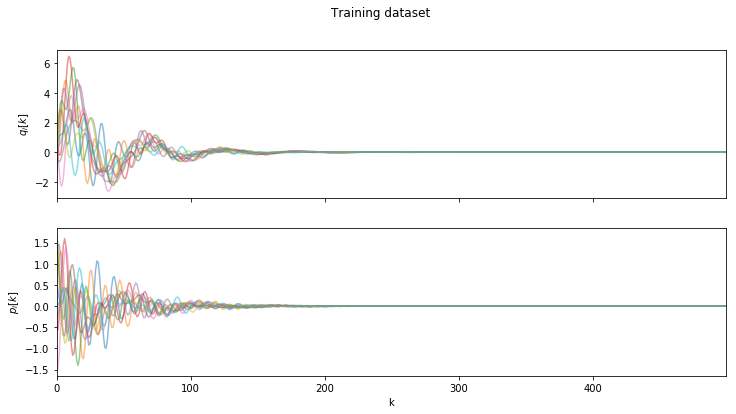

In [4]:
####################################
#####                          #####
#####     TRAINING DATASET     #####
#####                          #####
####################################

# --> Training initial condition.
x0_train = normal(
    loc=0.0,
    scale=1.0,
    size=(dsys.A.shape[1])
)

# --> Run simulation to generate dataset.
t, _, x_train = dlsim(dsys, np.zeros((500, dsys.inputs)), x0=x0_train)

# --> Setup the figure.
fig, axes = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(fig_width, fig_width/2),
)

# --> Plot the oscillators' positions.
axes[0].plot(
    t, x_train[:, :dsys.inputs],
    alpha=0.5,
)

# --> Add decorators.
axes[0].set_ylabel(r"$q_i[k]$")

# --> Plot the oscillators'velocities.
axes[1].plot(
    t, x_train[:, dsys.inputs:],
    alpha=0.5,
)

# --> Add decorators.
axes[1].set_xlabel(r"k")
axes[1].set_xlim(t.min(), t.max())

axes[1].set_ylabel(r"$p_i[k]$")

# --> Figure's title.
fig.suptitle(r"Training dataset")

Text(0.5, 0.98, 'Testing dataset')

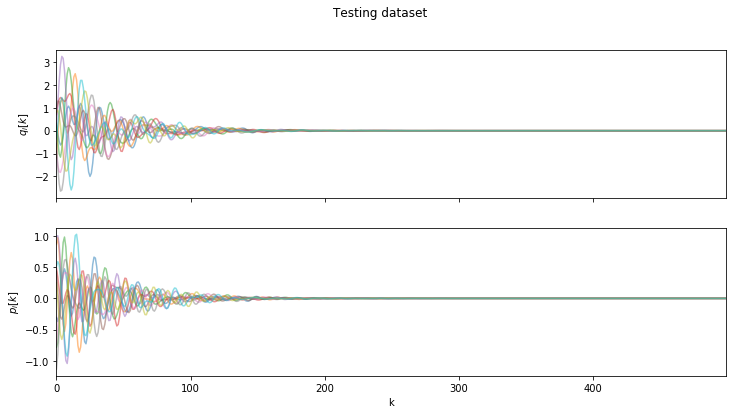

In [5]:
###################################
#####                         #####
#####     TESTING DATASET     #####
#####                         #####
###################################

# --> Testing initial condition.
x0_test = normal(
    loc=0.0,
    scale=1.0,
    size=(dsys.A.shape[1])
)

# --> Run simulation to generate dataset.
t, _, x_test = dlsim(dsys, np.zeros((500, dsys.inputs)), x0=x0_test)

# --> Setup the figure.
fig, axes = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(fig_width, fig_width/2),
)

# --> Plot the oscillators' positions.
axes[0].plot(
    t, x_test[:, :dsys.inputs],
    alpha=0.5,
)

# --> Add decorators.
axes[0].set_ylabel(r"$q_i[k]$")

# --> Plot the oscillators'velocities.
axes[1].plot(
    t, x_test[:, dsys.inputs:],
    alpha=0.5,
)

# --> Add decorators.
axes[1].set_xlabel(r"k")
axes[1].set_xlim(t.min(), t.max())

axes[1].set_ylabel(r"$p_i[k]$")

# --> Figure's title.
fig.suptitle(r"Testing dataset")

In [6]:
#####
#####
#####

# -->
dmd = DMD(svd_rank=dsys.A.shape[0]).fit(x_train.T)

In [7]:
#####
#####
#####

# -->
optdmd = optDMD(svd_rank=dsys.A.shape[0], factorization="evd").fit(x_train.T)

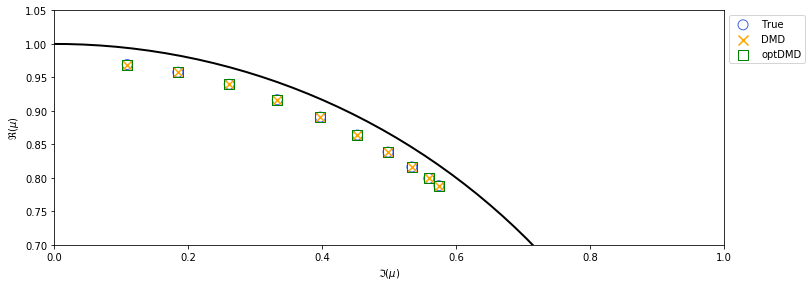

In [8]:
# --> Ground-truth eigenvalues.
mu = eigvals(dsys.A)

# --> Generate figure.
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))

# --> Plot the ground-truth eigenvalues.
ax.scatter(
    mu.imag, mu.real,
    facecolor="None",
    edgecolor="royalblue",
    label=r"True",
    s=100,
)

# --> Plot the DMD eigenvalues.
ax.scatter(
    dmd.eigs.imag, dmd.eigs.real,
    marker="x",
    color="orange",
    label="DMD",
    s=100,
)

ax.scatter(
    optdmd.eigs.imag, optdmd.eigs.real,
    marker="s",
    facecolor="None",
    edgecolor="green",
    label="optDMD",
    s=100,
)

# --> Add the unit-circle.
theta = np.linspace(0, 2*np.pi, 256)
ax.plot(
    np.cos(theta), np.sin(theta),
    color="black",
    linewidth=2,
)

# --> Add decorators.
ax.set_ylabel(r"$\Re(\mu)$")
ax.set_ylim(0.7, 1.05)

ax.set_xlabel(r"$\Im(\mu)$")
ax.set_xlim(0, 1)

ax.set_aspect("equal")

ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

In [9]:
y_train = x_train.T[:, 1:].T
X_train = x_train.T[:, :-1].T
y_predict = optdmd.predict(X_train.T).T

NotImplementedError: Prediction using the EVD factorization is not implemented yet.

In [ ]:
from scipy.linalg import norm
norm(y_predict-y_train)/norm(y_train)

In [ ]:
y_test = x_test.T[:, 1:].T
X_test = x_test.T[:, :-1].T
y_predict = optdmd.predict(X_test.T).T

In [ ]:
from scipy.linalg import norm
norm(y_predict-y_test)/norm(y_test)